In [13]:
import sys
import os
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from src.utility.h5_serializable_file import H5Serializable
import src.utility.utils as utils 
from uncertainties import ufloat
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
from src.wrapped_fits import WrappedFits
from src.utility import fits_file_utils as f_utils
import matplotlib.pyplot as plt

In [14]:
folder = "/home/nicho/venus/Research/TRAPPIST-1B/JWST"
visits = f_utils.get_fits_files_visits_in_folder(folder)
fits = WrappedFits(folder, visits[0], star_pixel_position = (697, 515))

75 pixels were bad out of 16129
667 values were interpolated out of 6080633
1166 values were outliers out of 6080633


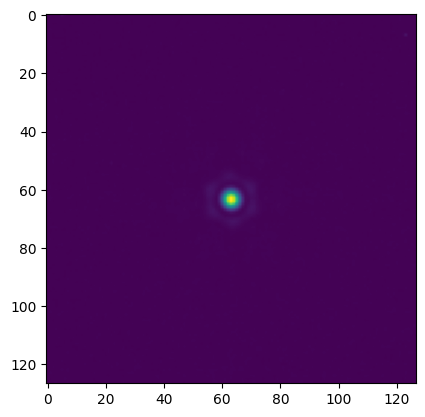

In [15]:
# Evaluating per-pixel light curves
frames = np.zeros_like(fits.raw_frames)
bad_pixel_count = 0
interpolated_pixel_count = 0
outlier_count = 0
bad_pixels = []
good_pixels = []
for i in range(0, frames.shape[1]):
	for j in range(0, frames.shape[2]):
		pixel_light_curve = fits.raw_frames[:,i,j]
		frames[:,i,j] = pixel_light_curve

		# First reject nan, 0
		nan = np.isnan(pixel_light_curve)
		zero = pixel_light_curve <= 0
		mask = np.logical_or(nan, zero)

		# If more than 75% of the observation was bad just ditch the pixel
		if mask.sum() > frames.shape[0] * 3 / 4:
			bad_pixel_count+=1
			bad_pixels.append((i,j))
			continue		
		else:
			good_pixels.append((i,j))

		if not (~mask).all():
			frames[:,i,j][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), pixel_light_curve[~mask])
			interpolated_pixel_count+=1

		pixel_light_curve = frames[:,i,j]
		# Now that nans are removed, do outlier detection
		outlier = np.abs(pixel_light_curve - np.median(pixel_light_curve)) > 5 * np.std(pixel_light_curve)
		if not (~outlier).all():
			outlier_count+=1
			frames[:,i,j][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), pixel_light_curve[~mask])

bad_pixel_mask = np.zeros_like(frames[0], dtype=bool)
for (x, y) in bad_pixels:
	bad_pixel_mask[x, y] = True

for ind, frame in enumerate(frames):
	# Now interpolate bad pixels based on the surrounding pixels
	# LinearNDInterpolator will not be able to fill in pixels outside of its convex hull
	# For those we use the neartest value in the grid: should only be happening in the background anyway where its very uniform
	linear_interp = LinearNDInterpolator(good_pixels, frame[~bad_pixel_mask])
	nearest_interp = NearestNDInterpolator(good_pixels, frame[~bad_pixel_mask])
	
	for i, j in bad_pixels:
		linear_interp_value = linear_interp(i, j)
		frames[ind, i, j] = linear_interp_value if not np.isnan(linear_interp_value) else nearest_interp(i, j)

pixels_per_frame = frames.shape[1]*frames.shape[2]
total_pixels = frames.shape[0] * frames.shape[1] * frames.shape[2]
print(f"{bad_pixel_count} pixels were bad out of {pixels_per_frame}")
print(f"{interpolated_pixel_count} values were interpolated out of {total_pixels}")
print(f"{outlier_count} values were outliers out of {total_pixels}")

plt.imshow(frames[0])
plt.show()